# Gene expression and clonality

This notebook explores the relationship between gene expression (a scRNA data set) and clonality.  The methods are intended for data consisting of hundreds (maybe thousands) of cells, belonging to clonotypes in roughly similar proportion, and a gene expression profile for each cell, for tens of thousands of genes.  

We carry out the following tasks in the sections below.

1.  Loading and munging of data.
2.  Exploration of differential gene expression.
3.  Machine learning and gene expression signatures
4.  Clustering with tSNE
5.  Application to data from another experiment.

## 1.  Loading and munging data

We begin by importing various packages and functions.  This notebook requires Python 3.5 or later, together with numpy, pandas, matplotlib, seaborn, statsmodels, scipy, scikit-learn (sklearn), bisect, and itertools.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
import statsmodels.api as sm

from IPython.display import display # Pretty display of data frames.

# Import various functions for stats.
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew # For detecting bimodality
from statsmodels.formula.api import ols

from bisect import bisect # See bisect.bisect.
from itertools import compress # I don't recall why this is here.

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn.preprocessing import Binarizer, MinMaxScaler

from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV

from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE

# Put plots inline rather than in a pop-up.
%matplotlib inline

The data should be in a pair of csv files in the working directory of this notebook.  The file with name PXXX_clonality.csv should have one column for each cell.  The first row should be the cell name.  The second row should contain the clonality of the cell.

The file with name PXXX_scnormed.csv should have one column for each cell.  The first row should be the cell name.  Each successive row should contain the gene expression counts for each gene.  The first column should contain the gene names.  The gene expressions should be normalized (*not* log-scaled) using SCnorm -- this can be accomplished within R.  

The following lines load the data into a Pandas dataframe, transpose the frames, then display the first few rows.  Change the filenames below as needed.

In [2]:
experiment = 'P1902' # Change this to the relevant experiment.

In [3]:
clone_df = pd.read_csv(experiment+'_clonality.csv', sep=',',
                      index_col=0, header=0, low_memory=False).transpose()
display(clone_df[:5])

gene_df = pd.read_csv(experiment+'_scnormed.csv', sep=',',
                      index_col=0, header=0, low_memory=False).transpose()
display(gene_df[:5])

,clonality
P1902_1293,A7
P1902_1294,A7
P1902_1295,A7
P1902_1296,A7
P1902_1301,A7


,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADAC,AADACL2,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
P1902_1293,0.0,0.000000,0.000000,8.239469,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.053019,0.412588,0.000000,0.000000,0.0
P1902_1294,0.0,0.000000,0.000000,0.103221,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001559,0.000000,0.0,0.0,0.0,0.077060,9.652112,0.000000,0.000000,0.0
P1902_1295,0.0,2.126955,0.000000,0.038361,0.0,0.0,0.0,0.0,0.0,0.0,...,33.992014,428.242112,0.0,0.0,0.0,0.072747,1.050288,3.186526,23.564989,0.0
P1902_1296,0.0,0.000000,45.534089,0.710352,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.299681,0.0,0.0,0.0,0.579323,0.174867,0.000000,0.000000,0.0
P1902_1301,0.0,12.533214,0.000000,4.995126,0.0,0.0,0.0,0.0,0.0,0.0,...,5.661078,0.000000,0.0,0.0,0.0,0.674957,0.044820,0.000000,0.000000,0.0


We extract the names of the genes and the names of the cells from the dataframe `gene_df`.

In [4]:
genes = list(gene_df.columns)  # The names of the genes. 
cells = list(gene_df.index) # The names of the cells.

T cells have special genetically rearranged receptors called TCRs.  These are made of segments called TRBV9, TRBJ2-4, TRAV12-2, TRAJ14, etc.  Bascally any gene that is called these letters followed by a number -- TRBV, TRBJ, TRAV, TRAJ -- is part of this receptor and they are defined as being clonal.  Therefore we exclude these genes since we want to find more interesting similarities within clonal populations.

The following loads a list of genes to be excluded from the data for later analysis.  The excluded genes should be given in a csv file with *one* column.  No row labels should be given.  The first row should be a descriptive header, like "Genes to exclude."

In [5]:
exc_filename = 'TRgenes.csv'  # CHANGE this if needed.
exc_df = pd.read_csv(exc_filename, sep=',', header=0)
exclude_genes = exc_df.iloc[:,0].tolist()

R might change hyphens to periods, in names of genes.  Therefore it may be necessary to make this change in the list `exclude_genes`.

In [6]:
exclude_genes = [gene.replace('-','.') for gene in exclude_genes] # R has changed - to .

We select genes as relevant if they are not excluded, and they are expressed sufficiently often at a level above a certain cutoff (the `expression_threshold`).  The function below determines whether or not a gene is relevant according to these criteria.

In [7]:
def get_relevant(gf, eg, prevalence=0.05, threshold = 10):
    '''
    Outputs True if the gene is relevant for analysis.  We throw out excluded genes.
    By default, we take genes that are found in at least 5% of all cells at a level of
    10 counts or more.
    '''
    nonzero_count = (gf > threshold).sum(axis=0)
    nonzero_proportion = nonzero_count / len(gf)
    return [gene for gene in gf.columns if
           (gene not in eg) and 
           (nonzero_proportion[gene] > prevalence)]

In [8]:
genes_relevant = get_relevant(gene_df, exclude_genes)

The following summarizes the data that has been loaded.  Double-check this, to make sure it matches expectation.

In [9]:
print("{} cells are measured, from {} to {}.".format(len(cells), cells[0], cells[-1])) 
print("{} genes are measured, from {} to {}.".format(len(genes),genes[0],genes[-1]))
genes_excluded = [gene for gene in exclude_genes if gene in genes]
print("{} TCR genes were excluded, from {} to {}.".format(len(genes_excluded), genes_excluded[0], genes_excluded[-1]))
print("{} genes are considered relevant, from {} to {}.".format(len(genes_relevant), genes_relevant[0], genes_relevant[-1]))

345 cells are measured, from P1902_1293 to P1902_1574.
19869 genes are measured, from A1BG to ZZZ3.
188 TCR genes were excluded, from TRGC1 to TRDJ4.
8663 genes are considered relevant, from A1BG to ZZZ3.


Now we make a list of the clonotypes, and a table of their populations.  For classification tasks, it is best if each clonotype has 40+ cells, though 30+ works alright.

In [10]:
clones = clone_df['clonality'].unique() 

#  Make population table of clonotypes
clonepop = clone_df['clonality'].value_counts().rename_axis('clonotype')
clonepop_df = clonepop.reset_index(name='N') # Put the clone populations in a dataframe.
clonepop_df.set_index('clonotype', inplace=True)
clonepop_df['proportion'] = clonepop_df['N'] / clonepop_df['N'].sum()

print("The populations of each of the {} clonotypes are displayed below.".format(len(clones)))
display(clonepop_df.transpose())

The populations of each of the 9 clonotypes are displayed below.


clonotype,F3,H2,E4,A7,B4,H9,G6,G8,A8
N,46.000000,45.000000,44.000000,43.000000,42.000000,33.000000,31.000000,31.000000,30.000000
proportion,0.133333,0.130435,0.127536,0.124638,0.121739,0.095652,0.089855,0.089855,0.086957


Now we create a dataframe which contains all the relevant information -- cells, clonality, and gene expression levels.  We first cut off all negative gene-expression, and then normalize the gene expression on a log-scale.  So a gene-expression value of $x$ will be replaced by $\log(1 + max(x,0))$ (natural logarithm).

In [11]:
genedf_log = gene_df[genes].copy()  # Make a copy in memory
genedf_log.clip_lower(0, inplace = True) # Clip negative counts to zero.
genedf_log = genedf_log.transform(np.log1p) # Apply log(1+x) transform.

Now we assemble our final working dataframe `df`, consisting of all the cells, their clonalities, and their expression levels for all of our relevant genes.

In [12]:
df = pd.concat([clone_df['clonality'], genedf_log[genes_relevant]], axis=1)
display(df[:5]) # Let's take a look at the first five cells.

,clonality,A1BG,A2ML1,AAAS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZSWIM1,ZSWIM7,ZSWIM8,ZUFSP,ZWILCH,ZWINT,ZYG11B,ZYX,ZZEF1,ZZZ3
P1902_1293,A7,0.0,2.223484,0.0,5.623830,0.000000,5.965800,0.163907,0.000000,0.000000,...,0.647175,6.334894,0.0,0.000000,0.000000,0.000000,0.345423,0.000000,0.000000,0.0
P1902_1294,A7,0.0,0.098235,0.0,4.231855,0.000000,0.629732,5.829559,0.000000,0.017289,...,0.491563,2.429200,0.0,0.000000,0.001558,0.000000,2.365758,0.000000,0.000000,0.0
P1902_1295,A7,0.0,0.037644,0.0,5.274331,4.165945,5.225426,4.780918,6.099587,0.000000,...,1.283508,0.022777,0.0,3.820477,3.555120,6.062021,0.717980,1.431871,3.201322,0.0
P1902_1296,A7,0.0,0.536699,0.0,1.301387,4.662237,6.218805,0.255867,0.000000,0.000000,...,0.336876,0.260956,0.0,0.000000,0.000000,0.832770,0.161155,0.000000,0.000000,0.0
P1902_1301,A7,0.0,1.790947,0.0,4.138285,5.391941,6.306859,0.009373,6.909654,0.000000,...,4.687328,0.049944,0.0,0.000000,1.896281,0.000000,0.043844,0.000000,0.000000,0.0


## 2.  Exploration of differential gene expression

Here we provide some tools for exploring individual genes, gene expression in different clonotypes, etc..  This will guide our model-building and later expectations.  This relies on the dataframe `df` constructed in the previous section, with all of the clonality and relevant gene expression.

In [13]:
def F_value(gene):
    '''
    Returns the ANOVA F-value, among nonzero gene expression values.
    A low F-value indicates statistically significant differences in 
    nonzero gene expression levels, among the clonotypes.
    '''
    testdf = df[['clonality', gene]]
    geneform = 'expression'
    testdf = testdf.rename(columns={gene : geneform})
    testdf = testdf.loc[testdf[geneform] > 0]
    if len(testdf) < 30: # Avoid low-sample-size problems.
        return 1
    mod = ols(geneform + ' ~ clonality', data=testdf).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    return aov_table['PR(>F)'][0]

In [14]:
def bimodality(gene):
    '''
    Returns the bimodality coefficient of an array of numbers.
    For more detail, see the article, 
    "Good things peak in pairs: a note on the bimodality coefficient,"
    Front Psychol. 2013; 4: 700.
    Roland Pfister et al.
    DOI: 10.3389/fpsyg.2013.00700
    Bimodality > 0.6 indicates possible bimodality.
    Bimodality < 0.4 indicates unimodality.
    '''
    arr = np.array(df[gene])
    arr = arr[arr > 0]
    n_arr = len(arr)
    numerator = skew(arr)**2 + 1
    n_term = (n_arr-1)**2 / ((n_arr-2)*(n_arr-3))
    denominator = kurtosis(arr) + 3*n_term
    return numerator / denominator

For later examination, we select some genes with high bimodality and low F-value.

In [15]:
# This will take a minute.
genes_bimodal = [gene for gene in genes_relevant if bimodality(gene) > 0.5]
genes_biF = [gene for gene in genes_bimodal if F_value(gene) < 1e-10]
print("{} genes selected for high bimodality and low F-value.".format(len(genes_biF)))

37 genes selected for high bimodality and low F-value.


The following function considers whether or not a gene is expressed (yes/no) rather than its expression level.  It measures the statistical significance of how this yes/no behavior differs among the clonotypes.

In [16]:
def onofflevel(gene):
    testdf = df[['clonality', gene]]
    geneform = 'expression'
    testdf = testdf.rename(columns={gene : geneform})
    testdf[geneform] = 0.9999*(testdf[geneform] == 0) # Convert to zeros and ones.
    noise = 0.000001*np.random.random_sample(len(testdf)) # Prevents singular matrix errors.
    testdf[geneform] += noise
    testdf = pd.get_dummies(testdf, columns=['clonality'])
    logit = sm.Logit(testdf[geneform], testdf[testdf.columns[1:]], method='bfgs')
    return logit.fit(disp=0).llr_pvalue

The following function is used to produce two graphs with summary statistics, to assist in the analysis of a single gene.  This may be helpful for qualitative analysis, e.g., of differential expression levels, on/off behavior and variations, etc..

In [17]:
def analyze(gene):
    '''
    Plots two graphs related to gene, with relevant statistics.
    One displays the on/off behavior of the gene.
    The other displays the tunability of the gene.
    '''
    sns.set_style("white")
    # Two subplots, unpack the axes array immediately
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    # Set the palette based on clonotypes.
    pal = {clones[i] : sns.color_palette("Set1",n_colors = len(clones))[i] for i in range(len(clones))}
    
    ## On/off Analysis on Plot #1
    overall = np.array(df[gene])
    N = len(overall)
    nz_N = np.count_nonzero(overall)
    nz_ratio = nz_N / N
    outliers = 0
    if 0.02 < nz_ratio < 0.98:
        # Now, we overlay distributions for each clone in a different color.
        for clone in clones:
            clone_exp = np.array(df[df.clonality == clone][gene])
            cN = len(clone_exp)
            cnz = np.count_nonzero(clone_exp)
            cr = cnz / cN
            rv = binom(cN,nz_ratio) # Binomial distribution, using overall nonzero-ratio
            x = range(cN+1)
            y = rv.pmf(x)
            ymax = max(y)
            x_window = [i for i in x if y[i] > 0.001*ymax]
            x_plot = [i/cN for i in x_window]
            y_plot = [y[i]*cN for i in x_window]
            sns.lineplot(x_plot,y_plot, color=pal[clone], alpha=0.1, ax=ax1)
            ax1.fill_between(x_plot,y_plot, color=pal[clone], alpha=0.1)
            pr = rv.pmf(cnz)
            if pr > 0.05*ymax:
                y_top = pr*cN
                l_style = '-'
            else:
                y_top = 0.2*ymax*cN
                l_style = '--'
                outliers += 1
                ax1.plot(cr, y_top, 'D', color=pal[clone])
            ax1.vlines(cr, 0, y_top, linestyles=l_style, colors=pal[clone], lw=2, label=clone)
        axtitle = str.join('\n',['On/off ratios for {} among {} cells.',
                           'Overall on/off ratio {:1.3f} with {} outlier(s).',
                           'Logit LLR p-value {:1.3g}.']).format(gene, N, nz_ratio, outliers, onofflevel(gene))
    elif nz_ratio <= 0.02:
        axtitle = "Only {} cells out of {}, with nonzero expression of {}".format(nz_N,N,gene)
        ax1.axis('off')
    elif nz_ratio >= 0.98:
        axtitle = "Over 98% of cells have nonzero expression of {}".format(gene)
        ax1.axis('off')
    ax1.set_title(axtitle)
    ax1.set_ylabel('Likelihood based on overall on/off ratio')
    ax1.set_xlabel('On/off ratios')
    #ax1.legend()
    
    ## Nonzero Analysis on Plot #2
    # First, we draw the distribution of nonzero gene-expression for all cells, in gray.
    overall = np.array(df[gene])
    overall = overall[np.nonzero(overall)]
    bim = bimodality(gene) # Bimodality Coefficient
    F = F_value(gene) # ANOVA F-value
    N = len(overall)
    if len(overall) >= 10:
        ax2 = sns.distplot(overall, hist=False, kde=True, color='gray',
                     kde_kws={'bw':0.5, 'label':'Overall', 'shade': True}, ax=ax2)
        ax2.set_xlim(2.3,12)
        axtitle = str.join('\n',['Nonzero {} expressions among {} cells.',
                                    'Bimodality Coeff={:1.3f} (Higher indicates multimodal)', 
                                     'ANOVA F={:1.3g}']).format(gene, N, bim, F)
    else:
        axtitle = "Less than 10 cells with nonzero expression of {}".format(gene)
        ax2.axis('off')
    
    # Now, we overlay distributions for each clone in a different color.
    for clone in clones:
        clone_exp = np.array(df[df.clonality == clone][gene])
        clone_exp = clone_exp[np.nonzero(clone_exp)]
        if len(clone_exp) >= 10:
            sns.distplot(clone_exp, hist=False, rug=True, kde=True, color = pal[clone],
                         kde_kws={'bw':0.5, 'label':clone}, ax = ax2)
    ax2.set_title(axtitle)
    ax2.set_ylabel('Relative frequency')
    ax2.set_xlabel('Gene expression level (log-scale)')
    f.suptitle('Analysis of {}'.format(gene), fontsize=14)

We demonstrate the `analyze` function on some interesting genes.

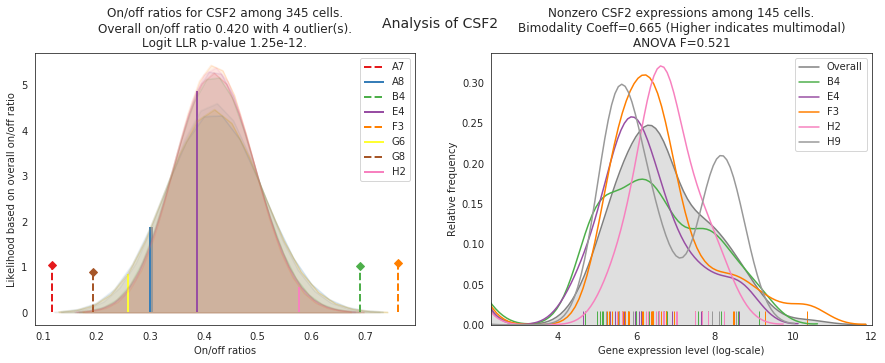

In [18]:
analyze('CSF2')

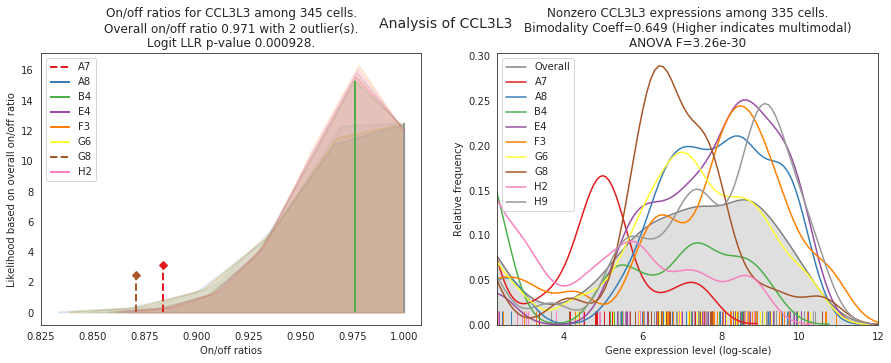

In [19]:
analyze(genes_biF[3]) # A gene selected for low F-value, hi bimodality.

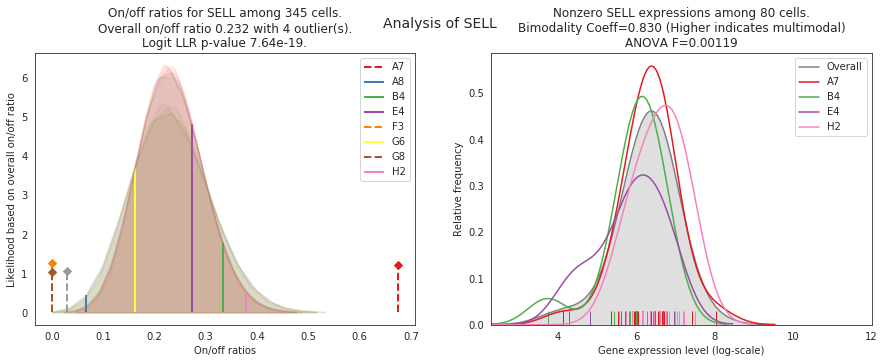

In [20]:
analyze('SELL') # A well-known gene, I think.

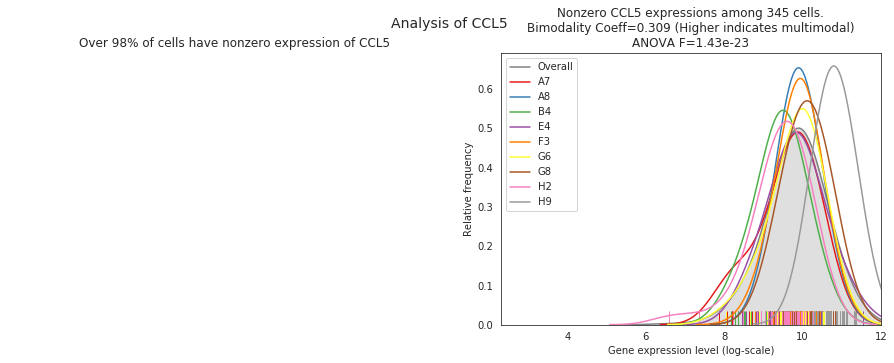

In [21]:
analyze('CCL5') # A gene which is almost always expressed.

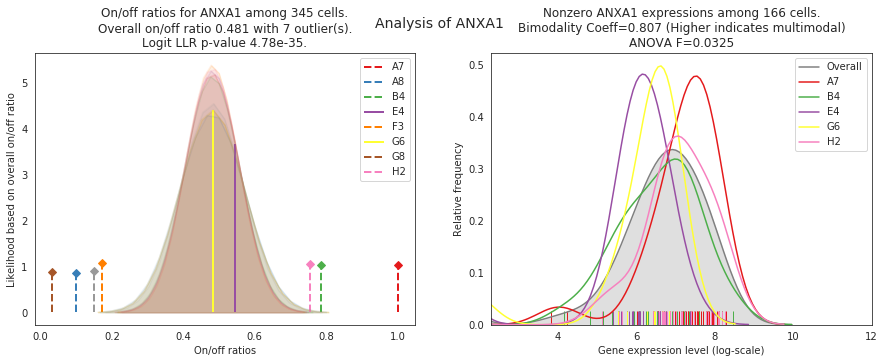

In [22]:
analyze('ANXA1')

Our `analyze` function looks at two kinds of behavior -- whether a gene is expressed or not, and the level of gene expression (when nonzero).  It seems important to consider whether these behaviors are correlated, e.g., whether a low-expressing gene also drops out frequently.  We look at this independently of clonotype.

## 3.  Machine learning and gene expression signatures

A central question is whether gene expression is a "signature" of clonality.  T-cells allow us to study this question because (1) the TCR genes certainly do provide a signature of clonality, so we *know* the clonotype of every cell, and (2) excluding the TCR genes, we can examine whether broad gene expression is a signature of this clonotype.  

We take a supervised machine learning approach to this question.  In this approach, a "signature" of clonality means that we can train the computer to predict clonality from gene expression.  We consider machine learning with Naive Bayes classifiers -- this approach also picks out "significant" genes -- and with a support vector machine (SVM) that provides better predictive accuracy. 

Using scikit-learn, the data is separated into an array `X` of gene expression (the "features") and an array `y` of clonalty (the "classes").

In [23]:
X = df[genes_relevant]  # The features.
y = df.clonality # We are trying to predict clonality from the features.

For comparison to random assignment to clonotypes, i.e. a null hypothesis, we also produce a shuffled list of clonality.

In [24]:
yshuff = pd.Series(np.random.permutation(y.values), index=y.index)

### Naive Bayes approach

scRNA gene expression data is complicated by dropouts (zeros) of biological and technical origin, some false-identifications (low expression counts which should be zero), and a generally complicated "real" distribution of gene expression in each cell.  A common model is ZINB (zero-inflated negative binomial), which is studied in [Risso et al.](https://www.nature.com/articles/s41467-017-02554-5), for example.

The ZINB model has three parameters (see Methods of loc. cit.), capturing dropout frequency and mean and dispersion (of the negative-binomial distribution).  Our Bayesian approach is a modification, which captures three closely related statistics:  the zero-frequency (with a threshold hyperparameter) and the mean/std of the nonzero expressions.  This approach is computationally simpler (using existing tools) and separates phenomena which may have distinct biological origins.

Our Bayesian approach has two components: 

-  (Type B, for Binarized/Bernoulli) We binarize gene expression -- either a gene is expressed (above a threshold) or not.  We may use binarized gene expression to predict clonotype, choosing the most variable (binarized) genes by a $\chi^2$ statistic.  The hyperparameters are the threshold and the number of genes used for prediction.

- (Type G for Gaussian)  We consider only genes that are frequently expressed.  We use differential expression of such genes to predict clonotype, choosing the most variably-expressed genes by an ANOVA F-statistic.  The hyperparameters are the number of frequently expressed genes in the first pool, and the number of differentially expressed genes used for prediction.   

We carry out both analyses, and also study an ensemble classifier which allows these two classifiers to "vote" on clonotype.

Type B:  The Bernoulli Naive Bayes Pipeline

We create a scikit-learn pipeline with three steps:  binarization, feature selection (selecting genes by a $\chi^2$-statistic), then using a Bernoulli Naive Bayes classifier.

In [25]:
BNBpipe = make_pipeline(Binarizer(), SelectKBest(score_func = chi2), BernoulliNB())

To analyze the predictive power, we carry out 5-fold cross-validation on a grid of hyperparameters.  The first hyperparameter is the threshold for gene expression (for binarization).  The second is the number of genes (selected by $\chi^2$-statistic) used for prediction.

In [26]:
param_grid = dict(binarizer__threshold=[0.01, 0.05, 0.075, 0.1, 0.2, 0.5, 1.0, 1.5, 2.0],
                  selectkbest__k = range(10,200,10),
                 )

grid_search = GridSearchCV(BNBpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('binarizer', Binarizer(copy=True, threshold=0.0)), ('selectkbest', SelectKBest(k=10, score_func=<function chi2 at 0x1c1a6be488>)), ('bernoullinb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'binarizer__threshold': [0.01, 0.05, 0.075, 0.1, 0.2, 0.5, 1.0, 1.5, 2.0], 'selectkbest__k': range(10, 200, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Next, we create a general-purpose visualization for grid-search cross-validations.

In [47]:
def CV_map(gs):  # parameter_grid and grid_search.
    means = gs.cv_results_['mean_test_score']
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in gs.cv_results_['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(list(gs.param_grid.keys())[1])
    ax.set_ylabel(list(gs.param_grid.keys())[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))

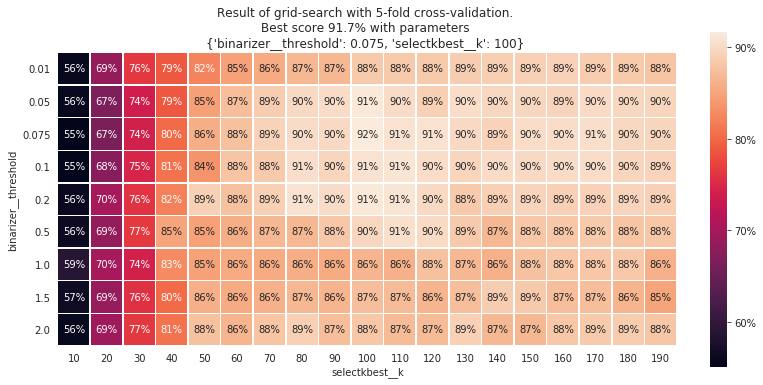

In [48]:
CV_map(grid_search)

We find that *binarized* gene expression data (whether a gene is expressed or not) yields a 91.7% accurate predictor of clonotype, once hyperparameters are tuned (around 100 genes, with expression cutoff at 0.075).

We can also look at the "confusion matrix" of such a prediction, with tuned hyperparameters.

In [50]:
opt_threshold = grid_search.best_params_['binarizer__threshold']
opt_k = grid_search.best_params_['selectkbest__k']
print('Using tuned threshold {} and k={}'.format(opt_threshold, opt_k))

Using tuned threshold 0.075 and k=100


We create a general-purpose visualization for "confusion matrices."

In [257]:
def validate_map(predicted, actual):
    correct = 0
    #total = 0 
    classes = sorted(list(set(actual) | set(predicted)) )
    counts = pd.DataFrame(0, index=classes, columns=classes)
    #cpops = pd.DataFrame(0,index=classes, columns=['pop'])
    cpops = actual.value_counts().sort_index()
    for j in range(len(actual)):
        if actual[j] == predicted[j]:
            correct += 1
        #cpops.loc[actual[j],'pop'] += 1
        counts.loc[actual[j], predicted[j]] += 1
        #total += 1
    valid = counts.apply(lambda column : column/cpops) #['pop'] )
    
    f, ax = plt.subplots(figsize=(8,7))
    sns.heatmap(valid, annot=counts, square=True, fmt="d", linewidths=.5, 
                cbar_kws={'fraction':0.046, 'pad':0.04}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .5, .75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_ylabel("Actual class")
    ax.set_xlabel("Predicted class")
    ax.set_title("Class prediction accuracy {:0.3%}.".format(correct/len(actual))) #total))

We run our Bernoulli Naive Bayes pipeline to study its predictions in more detail.  The data is divided into training and validation sets, in an 80%/20% ratio.  The classifier is trained on 80% and validated on 20%.  The "confusion matrix" displays the actual class (i.e., clonotype) and predicted class for each cell among the 20% in the validation set.

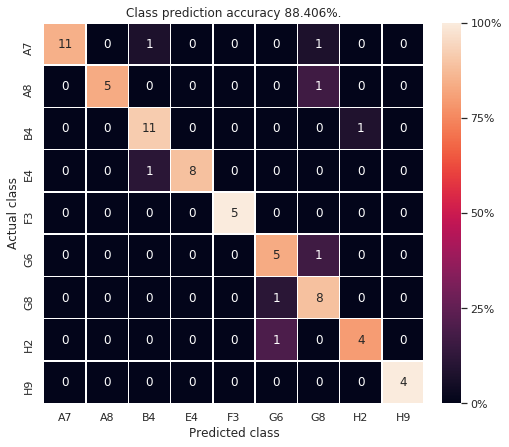

In [261]:
BNBpipe = make_pipeline(Binarizer(threshold=opt_threshold), 
                        SelectKBest(score_func = chi2, k=opt_k), 
                        BernoulliNB())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
BNBpipe.fit(X_train, y_train)
y_pred = BNBpipe.predict(X_test)
validate_map(y_pred,y_test)

To compare to the "null hypothesis", we apply the same predictive pipeline to the data with clonotype-labels randomly shuffled.  The expected accuracy is about 100% divided by the number of classes (around 11% in this case).

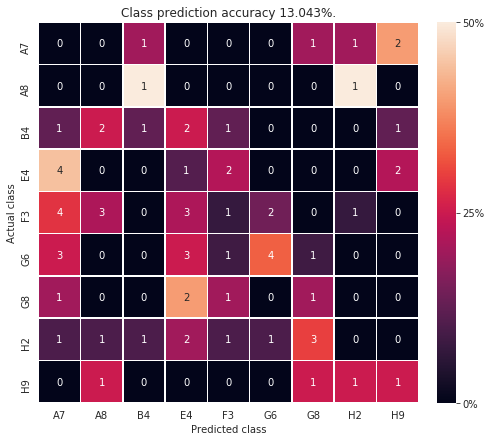

In [91]:
BNBpipe = make_pipeline(Binarizer(threshold=opt_threshold), 
                        SelectKBest(score_func = chi2, k=opt_k), 
                        BernoulliNB())

X_train, X_test, y_train, y_test = train_test_split(X, yshuff, test_size=0.2)
BNBpipe.fit(X_train, y_train)
y_pred = BNBpipe.predict(X_test)

validate_map(y_pred,y_test)

Type G:  The Gaussian Naive Bayes Pipeline.

Now we carry out a similar analysis using a Gaussian Naive Bayes classifier.  The general purpose visualizers are the same as before.

The pipeline has three steps:

1.  Selecting only genes which are frequently expressed (above a cutoff of 0.1).
2.  From this pool, select the genes whose expression levels vary most between classes.
3.  Train the Gaussian Naive Bayes classifier on these selected genes.

Step 1 requires a custom scoring for frequency of expression.  Step 2 uses an ANOVA F-statistic for scoring (which is built in).

In [88]:
def express_score(X,y):
    '''
    Scoring a gene based on frequency of expression.
    '''
    return np.array((X>0.1).sum(axis=0))

In [89]:
GNBpipe = Pipeline([ ('expr',SelectKBest(express_score, k=600)), 
                    ('fval',SelectKBest(f_classif, k=100)), 
                    ('gnb',GaussianNB()) ]) 

We carry out 5-fold cross-validation on a grid of hyperparameters.  The two hyperparameters are the number of genes in the pool of *frequently* expressed genes, and the number of genes in the subpool of *differentially* expressed genes.  These are called `expr__k` and `fval__k`, respectively.

In [90]:
param_grid = dict(
                  expr__k = range(200,601,40), fval__k = range(10,151,10)
                 )

grid_search = GridSearchCV(GNBpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('expr', SelectKBest(k=600, score_func=<function express_score at 0x1c21986730>)), ('fval', SelectKBest(k=100, score_func=<function f_classif at 0x1c1a6be378>)), ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'expr__k': range(200, 601, 40), 'fval__k': range(10, 151, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The results of cross-validation are displayed below, along with the optimal hyperparameters.

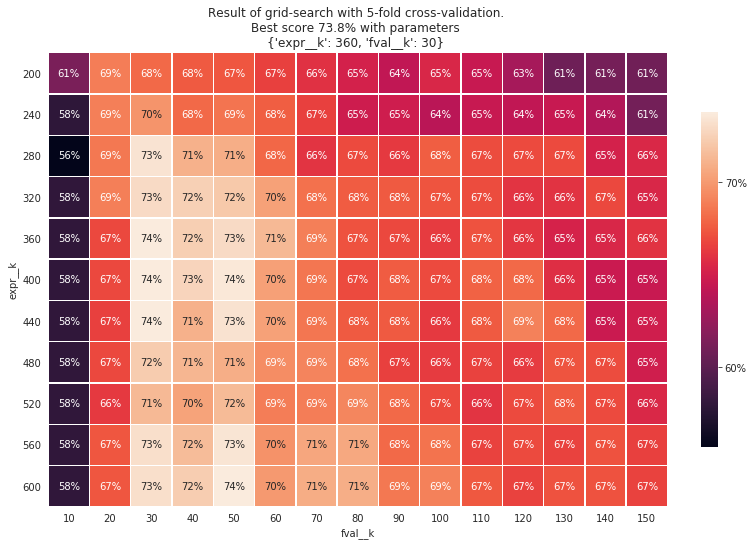

In [93]:
CV_map(grid_search)

We create a confusion matrix, to study the predictions in more detail, when hyperparameters are tuned.

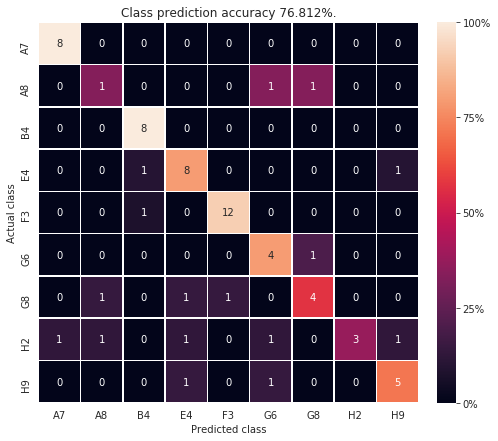

In [96]:
opt_expr__k = grid_search.best_params_['expr__k']
opt_fval__k = grid_search.best_params_['fval__k']
GNBpipe = Pipeline([ ('expr',SelectKBest(express_score, k=opt_expr__k)), 
                    ('fval',SelectKBest(f_classif, k=opt_fval__k)), 
                    ('gnb',GaussianNB()) ]) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

GNBpipe.fit(X_train, y_train)
y_pred = GNBpipe.predict(X_test)

validate_map(y_pred,y_test)

### Ensemble classifier

Next we implement an ensemble classifier, which allows the Type B (Bernoulli Naive Bayes) and Type G (Gaussian Naive Bayes) to "vote" on the clonotype of each cell.  We choose some hyper-parameters and cross-validate on others... just to see what happens.  We don't fully optimize this ensemble classifier.

In [97]:
BNBpipe = make_pipeline(Binarizer(), SelectKBest(score_func = chi2), BernoulliNB())
GNBpipe = Pipeline([ ('expr',SelectKBest(express_score, k=600)), 
                    ('fval',SelectKBest(f_classif, k=100)), 
                    ('gnb',GaussianNB()) ]) 

# Weights [0.8, 0.2] give Type B 80% and Type G 20% in a weighted vote.

eclf = VotingClassifier(estimators=[('bnb',BNBpipe), ('gnb',GNBpipe)], 
                              voting='soft', weights=[0.8,0.2]) 
eclf.set_params(bnb__binarizer__threshold=0.075)
eclf.set_params(gnb__expr__k=360)

VotingClassifier(estimators=[('bnb', Pipeline(memory=None,
     steps=[('binarizer', Binarizer(copy=True, threshold=0.075)), ('selectkbest', SelectKBest(k=10, score_func=<function chi2 at 0x1c1a6be488>)), ('bernoullinb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])), ('gnb', Pipeline(mem...nc=<function f_classif at 0x1c1a6be378>)), ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))]))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[0.8, 0.2])

In [98]:
param_grid = dict(bnb__selectkbest__k = range(60,161,10),
                  gnb__fval__k = range(10,91,10)
                 )

grid_search = GridSearchCV(eclf, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=VotingClassifier(estimators=[('bnb', Pipeline(memory=None,
     steps=[('binarizer', Binarizer(copy=True, threshold=0.075)), ('selectkbest', SelectKBest(k=10, score_func=<function chi2 at 0x1c1a6be488>)), ('bernoullinb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True...-09))]))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[0.8, 0.2]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'bnb__selectkbest__k': range(60, 161, 10), 'gnb__fval__k': range(10, 91, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

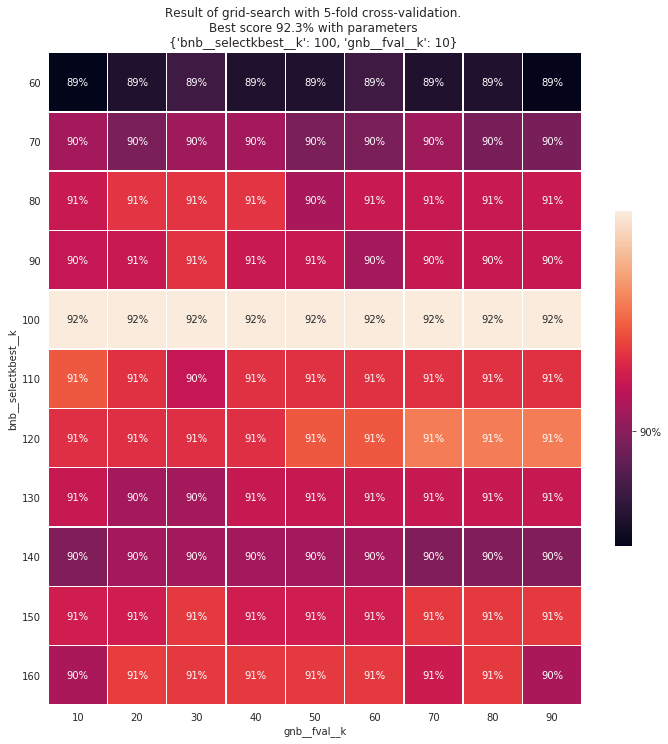

In [100]:
CV_map(grid_search)

The ensemble classifier does not seem to perform much better than the binarized Bernoulli Naive Bayes on its own.  One could tune the weightings, thresholds, etc., to see what happens, of course.

### Support Vector Machine classifier

Next, we take an entirely different approach to classification, using a soft-margin linear support vector classifier.  This is implemented in scikit-learn with the `LinearSVC` classifier.  Our pipeline has three steps.

1.  We pre-process the data by applying a scaling function -- all gene-expressions will be scaled to lie between 0 and 1.  This is necessary, since LinearSVC is not scale-independent.

2.  We select the most significant genes based on ANOVA F-statistic, i.e., looking for differential gene expression.  Note that we look at genes regardless of expression-frequency.

3.  We apply the LinearSVC classifier.

In [101]:
SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=100), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000))

We use 5-fold cross-validation and a grid search on the two most important hyperparameters.  These hyperparameters are the number of genes used in the classifier, and the C-parameter for the SVM.  In LinearSVC, the classifier tries to separate clonotypes by hyperplanes in gene-expression space.  Hyperplanes are scored by two criteria:

1.  Hyperplanes are considered better when the samples are farthest away from them (size of margin).

2.  Samples on the "wrong" side of the hyperplane count against the score, proportionally to how far on the wrong side they lie.  The C-parameter determines the penalty for these badly located samples, i.e., a higher C-parameter will be less tolerant of samples on the wrong side of the hyperplane.

In [107]:
# Expect convergence warnings!  Increase max_iter above if you don't want them.

param_grid = dict(linearsvc__C=[0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                  selectkbest__k = range(50,1051,100),
                 )

grid_search = GridSearchCV(SVMpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

//anaconda/envs/Genomics/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda/envs/Genomics/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda/envs/Genomics/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda/envs/Genomics/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda/envs/Genomics/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the num

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=350, score_func=<function f_classif at 0x1c1a6be378>)), ('linearsvc', LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'linearsvc__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000], 'selectkbest__k': range(50, 1051, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

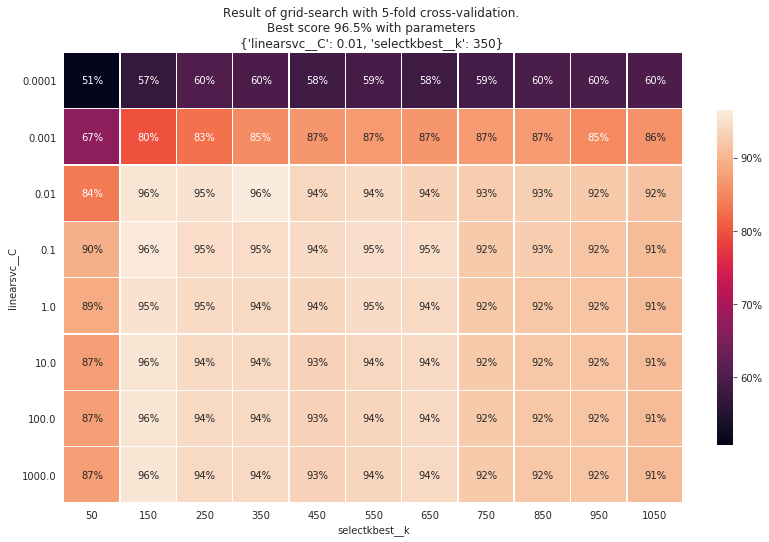

In [104]:
CV_map(grid_search)

With minimal tuning, the SVM classifier (LinearSVC) exhibits better predictive accuracy than either of the Naive Bayes classifiers (even when they are coupled).  On the P1902 data, the SVM classifier achieves 96.5% accuracy with about 350 genes and C=0.01. This might be as good as it gets, though one could try other classifiers (e.g. neural net) just to see.

To see it in action in a single instance (rather than a grid of cross-validations), we run it with tuned parameters below.

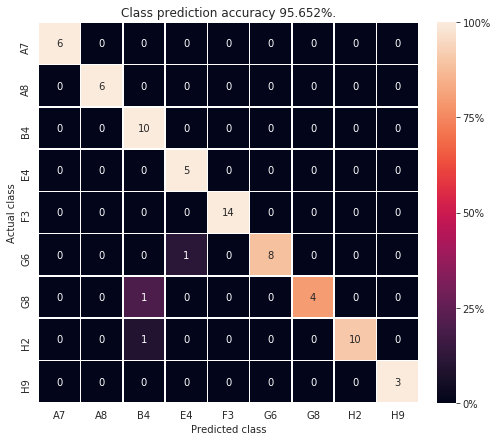

In [106]:
opt_k = grid_search.best_params_['selectkbest__k']
opt_C = grid_search.best_params_['linearsvc__C']

SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=opt_k), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=opt_C))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

SVMpipe.fit(X_train, y_train)
y_pred = SVMpipe.predict(X_test)

validate_map(y_pred,y_test)

### Visualizing gene expression signatures

Our Naive Bayes pipelines selected genes based on differential gene expression -- either binarized by $\chi^2$ statistic (in the Type B pipeline) or by F-statistic (in the type G pipeline).  

Here we apply these gene selection filters on the *entire* data set (no training/testing split) to see which genes are most significant for each approach.  We then plot the gene expression signatures of each clonotype, with some automated clustering of genes and clones.

We call the significant genes "blue genes" and "green genes" for the B and G type pipelines described above.  We identify these genes below, starting with the blue genes.

In [115]:
Bpipe = make_pipeline(Binarizer(threshold=opt_threshold), 
                        SelectKBest(score_func = chi2, k=100)) # 100 blue genes.

Bpipe.fit_transform(X,y)
B_gene_nums = Bpipe.named_steps['selectkbest'].get_support(indices=True)
B_genes = list(X.columns[B_gene_nums])
print("The {} blue genes are: {}".format(len(B_genes), ', '.join(B_genes)))

The 100 blue genes are: AFDN, AHNAK, AKR1C3, ANXA1, AOAH, ASB2, C1orf21, C3orf14, C7orf50, CAPG, CCL20, CCL23, CCR2, CD200R1, CD300A, CD40LG, CD9, CDKN1A, CLECL1, CLIC3, CSF1, CSF2, CTD.2116N17.1, CTSH, CTSL, CXCR3, CXCR6, DFNA5, DNAJC9, DTL, EOMES, EPAS1, FAM49A, FCGR3A, FCGR3B, FEZ1, FLT4, GGT1, GLUL, GNG8, GPR15, GZMK, HLA.DPA1, HLA.DPB1, HLA.DQB1, HLA.DRA, HLA.DRB5, HOXB2, ID3, IFI44L, IL18RAP, ISG20, ITGAM, ITM2C, JAML, KIF22, KLRB1, KLRC3, LAIR2, LGALS3BP, LIME1, LTA, LYAR, MCM2, MCM3, MCM5, MKI67, MT2A, MX1, MYO1E, NAA10, NCF1, NT5E, PATL2, PER3, PLEK, PRKCE, PTPRN2, RCBTB2, REG4, RGS1, RP11.277P12.6, RP4.583P15.15, RUNX2, S1PR1, SELL, SLC31A2, SPOCK1, SRRT, STEAP1, STMN1, TC2N, TIMD4, TK1, TOP2A, TRAT1, TRDV3, USP18, ZBTB32, ZWINT


We create a clustermap to visualize the gene-expression signatures of each clonotype, using blue genes only.  We are only using binarized data here -- color represents the proportion of cells which have nonzero expression of each gene.  Genes and clonotypes are clustered by a correlation metric -- there is a lot of flexibility in clustering, so it should not be taken as a strong indicator, e.g., of biological relation.

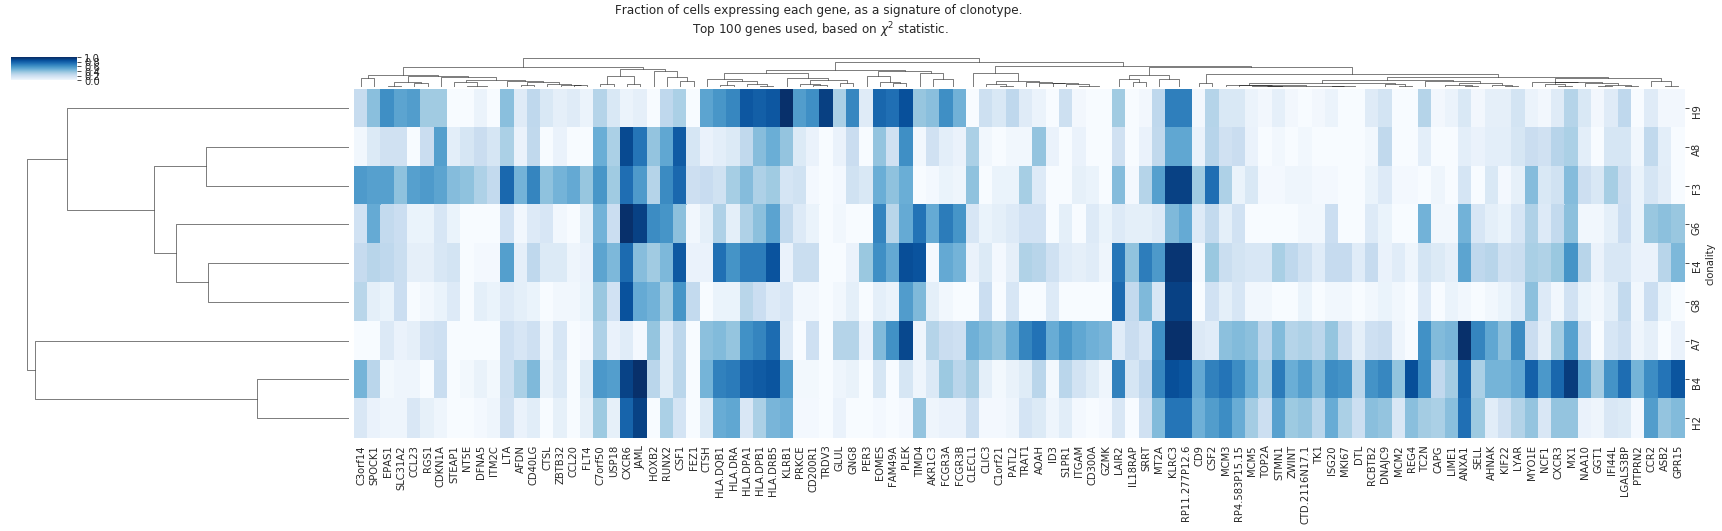

In [123]:
clones_nzr = df[B_genes+['clonality']].groupby('clonality').apply(
    lambda column: ((column != 0).sum())/(len(column)))
cm = sns.clustermap(clones_nzr[B_genes], cmap="Blues", metric='correlation', 
                        figsize=(30, 7), cbar_kws={'fraction':0.046, 'pad':0.06})
cm.fig.suptitle('Fraction of cells expressing each gene, as a signature of clonotype. \n'
                    'Top {} genes used, based on $\\chi^2$ statistic.'.format(len(B_genes)))
plt.show()

Now we carry out the same process for "green" genes.  These are genes that are frequently expressed, but whose expression-level is highly variable between clonotypes.  Note that we use the parameters obtained by previous GridSearchCV.  

In [124]:
Gpipe = Pipeline([ ('expr',SelectKBest(express_score, k=360)), 
                    ('fval',SelectKBest(f_classif, k=30))]) 

Gpipe.fit_transform(X,y)
exp_gene_nums = Gpipe.named_steps['expr'].get_support(indices=True)
exp_genes = list(X.columns[exp_gene_nums])
G_gene_nums = list(Gpipe.named_steps['fval'].get_support(indices=True))
G_genes = [exp_genes[gn] for gn in G_gene_nums]
print("The {} blue genes are: {}".format(len(G_genes), ', '.join(G_genes)))

The 30 blue genes are: ACTB, APOBEC3C, B2M, CCL3, CCL4, CCL4L2, CCL5, CD2, CD52, CLDN11, FGF23, FTL, GPM6A, GZMB, HS3ST1, IL32, KIN, KLRD1, LTB, MGA, MT.CO2, MT.CYB, NKG7, RAB12, SH3BGRL3, SRGN, TMSB10, TNFSF13B, TRAC, VLDLR


In [126]:
# Verify that B_genes and G_genes have no intersection!
list(set(B_genes).intersection(set(G_genes)))

[]

Now we visualize the gene-expression signatures of each clonotype using "green genes".  Color represents the mean gene expression for each gene and clonotype, as compared to the mean gene expression for the gene across all cells, in units of standard deviation of gene expression across all cells.  In this way, dark blue/green represents highly-expressed genes and dark brown represents low-expressed genes -- dropout is not an issue among these genes.

Clustering of genes and clones is by correlation, as before.

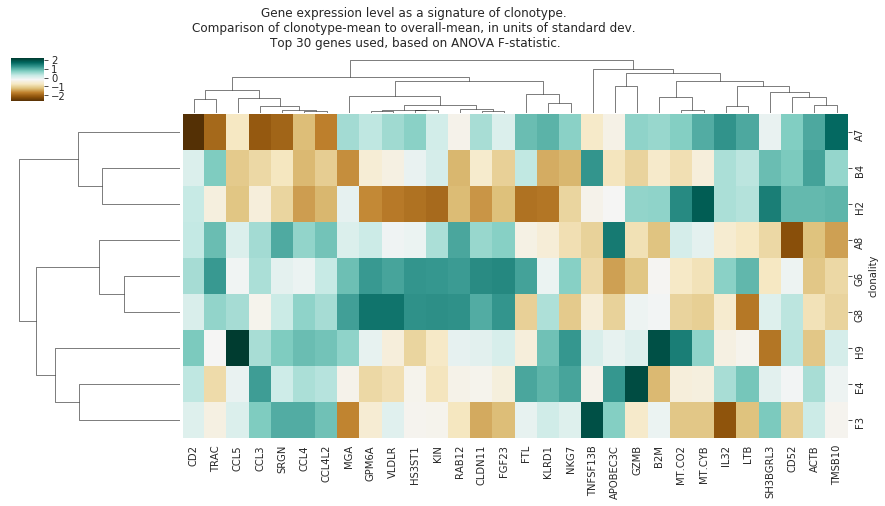

In [130]:
clones_var = df[G_genes+['clonality']].groupby('clonality').apply(
    lambda column: column.mean())
clones_var = clones_var.apply(
    lambda column: (column - column.mean()) / column.std() )
cm = sns.clustermap(clones_var[G_genes], cmap="BrBG", metric='correlation', 
                        figsize=(15, 7), cbar_kws={'fraction':0.046, 'pad':0.06})
cm.fig.suptitle('Gene expression level as a signature of clonotype. \n'
                    'Comparison of clonotype-mean to overall-mean, in units of standard dev. \n'
                    'Top {} genes used, based on ANOVA F-statistic.'.format(len(G_genes)))
plt.show()

## 4.  Clustering with tSNE

Clustering with tSNE is a reasonable way to visualize cells in a (somewhat) high-dimensional space of gene-expressions by (nonlinearly) reducing to two dimensions.  Here we apply tSNE using a Type B and Type G approach as before.  In the Type B approach, we binarize the gene expression, and use the most important genes as selected by $\chi^2$ statistic.  In the Type G approach, we limit our attention to almost-always expressed genes and those with most variable gene expression between clonotypes (by F-statistic).  By looking at the clusters with fewer or more genes in the high-dimensional space, and by annotating the plots according to gene expression, we can learn a bit more about how the gene expression distinguishes clonotypes. 

### Type B clustering

We carry out clustering first with a small number (10) of genes, and then with the "ideal" number (100) for classification, to see how clusters evolve with more genes.  A small number of genes will lead to some *identical* gene expression signatures, since we have binarized gene expression.

In [199]:
Bpipe = make_pipeline(Binarizer(threshold=0.5), 
                        SelectKBest(score_func = chi2, k=10)) 
Xred = Bpipe.fit_transform(X,y)
X_embedded = TSNE(n_components=2).fit_transform(Xred)
b_gene_nums = Bpipe.named_steps['selectkbest'].get_support(indices=True)
b_genes = list(X.columns[b_gene_nums])

//anaconda/envs/Genomics/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [200]:
def onsty_gene(X, gene):
    sg = X[gene] > 0.5
    sg = sg.apply(lambda x: gene + x*'+' + (not x)*'-')
    return sg

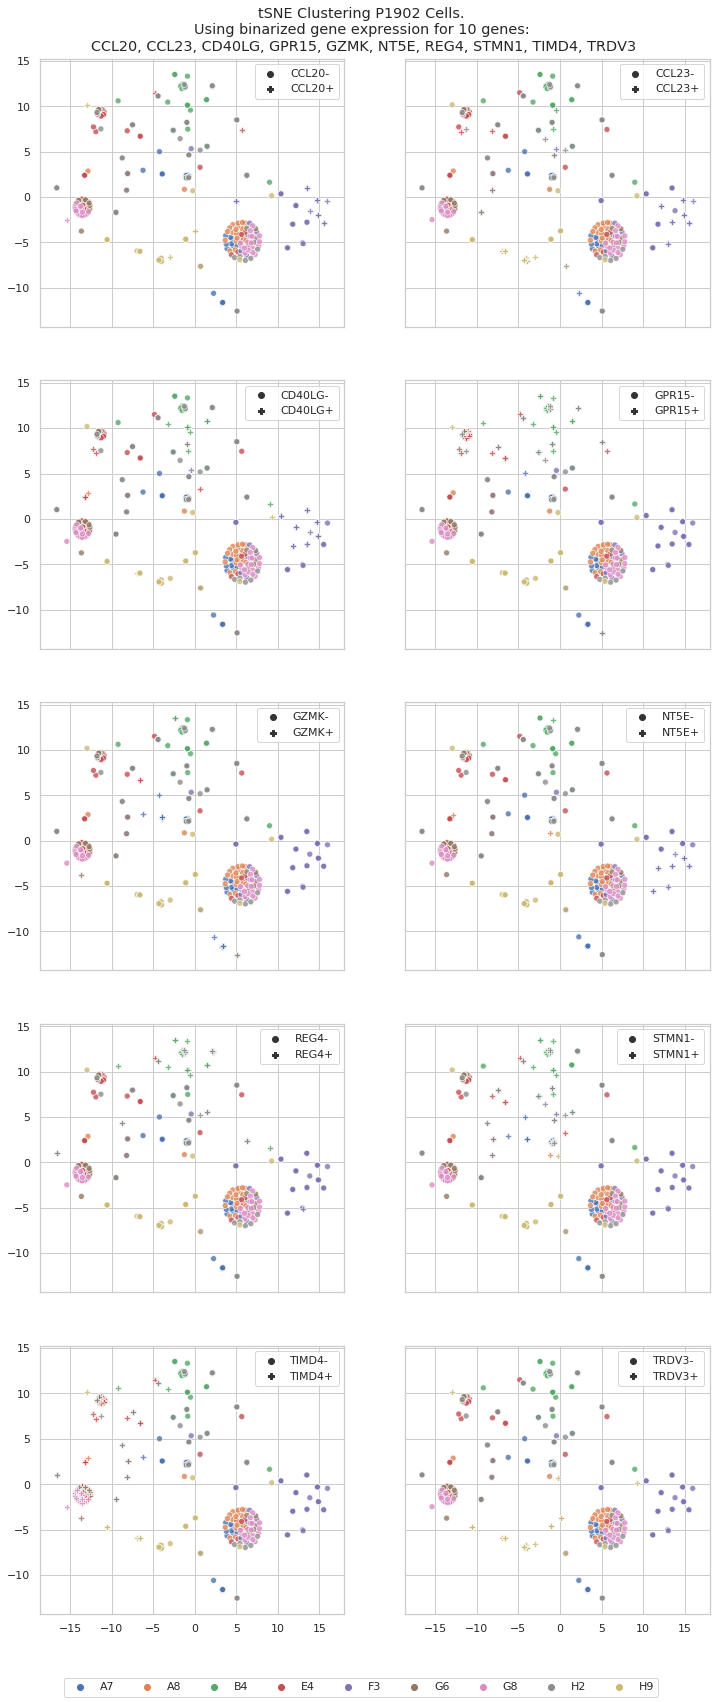

In [202]:
sns.set(style="whitegrid")
f, ax = plt.subplots(5,2,figsize=(12,24), 
                     sharex=True, sharey=True)

for i in range(5):
    for j in range(2):
        gene = b_genes[2*i + j]
        sp = sns.scatterplot(*zip(*X_embedded), hue=y, alpha=0.8,
                             style=onsty_gene(X,gene), 
                             style_order = [gene+'-', gene+'+'],
                             markers = ['o', 'P'],
                             ax=ax[i,j])
        handles, labels = ax[i,j].get_legend_handles_labels()
        handles = handles[-2:]
        labels = labels[-2:]
        
        ax[i,j].legend(handles, labels, title=None)
        
f.suptitle("tSNE Clustering P1902 Cells. \n"
             "Using binarized gene expression for {} genes: \n"
             "{}".format(len(b_genes),', '.join(b_genes)))
handles, labels = ax[0,0].get_legend_handles_labels()
handles = handles[1:-3]
labels = labels[1:-3]
plt.figlegend( handles, labels, loc = 'lower center', ncol=9)
plt.subplots_adjust(bottom=0.05, top=0.95)
plt.show()

The tight clusters above represent cells whose binarized expression of the 10 genes are the same.  For example, every cell in the largest cluster (mostly G8 and A8, bottom left) expressed *none* of the 10 genes.  But the other pinkish cluster (bottom right) is TIMD4+.

Next, we use the full set of 100 significant ($\chi^2$-statistic) genes to cluster after binarization.

In [222]:
Bpipe = make_pipeline(Binarizer(threshold=0.075), 
                        SelectKBest(score_func = chi2, k=100)) 
# Takes a second or two.
Xred = Bpipe.fit_transform(X,y)
X_embedded = TSNE(n_components=2).fit_transform(Xred)

//anaconda/envs/Genomics/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


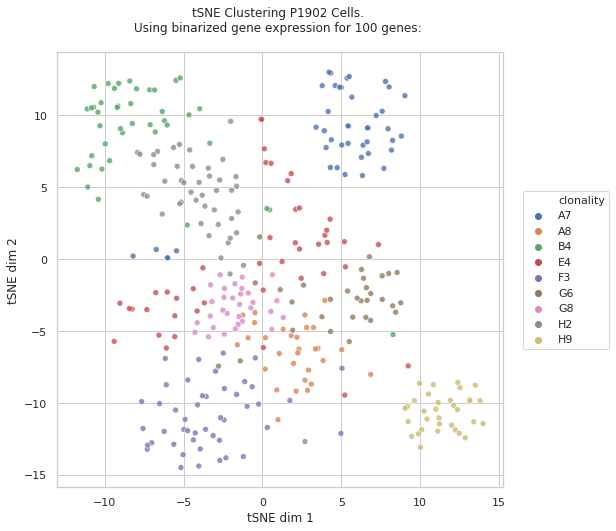

In [223]:
b_gene_nums = Bpipe.named_steps['selectkbest'].get_support(indices=True)
b_genes = list(X.columns[b_gene_nums])
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(*zip(*X_embedded), hue=y, alpha=0.8)
ax.set_xlabel("tSNE dim 1")
ax.set_ylabel("tSNE dim 2")
ax.set_title("tSNE Clustering P1902 Cells. \n"
             "Using binarized gene expression for {} genes: \n".format(len(b_genes)))
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

The clusters are evident, using the binarized gene expression from 100 genes.  This shows why we can achieve roughly 90% accuracy using this binarized gene expression to predict clonotype, and also why there might be frequent confusion between G8/A8/E4/H2 clones.  On the other hand, A7 and H9 clones belong to very distinctive clusters.

### Type G Clustering

Even though Type G classification was less accurate, it seems important to understand how *frequently-expressed* genes might distinguish clonotypes based on level of gene expression.  So we carry out an an analysis parallel to what's above, beginning with a 10-gene clustering.

In [211]:
Gpipe = Pipeline([ ('expr',SelectKBest(express_score, k=360)), 
                    ('fval',SelectKBest(f_classif, k=10))]) 

# Takes a second or two.
Xred = Gpipe.fit_transform(X,y)
X_embedded = TSNE(n_components=2).fit_transform(Xred)

//anaconda/envs/Genomics/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [212]:
exp_gene_nums = Gpipe.named_steps['expr'].get_support(indices=True)
exp_genes = list(X.columns[exp_gene_nums])
g_gene_nums = list(Gpipe.named_steps['fval'].get_support(indices=True))
g_genes = [exp_genes[gn] for gn in g_gene_nums]
print(g_genes)

['ACTB', 'B2M', 'CCL4', 'CCL4L2', 'CCL5', 'CD2', 'IL32', 'KIN', 'KLRD1', 'TNFSF13B']


In [213]:
def sty_gene(X, gene):
    sg = X[gene] > X[gene].mean()
    sg = sg.apply(lambda x: gene + x*'high' + (not x)*'low')
    return sg

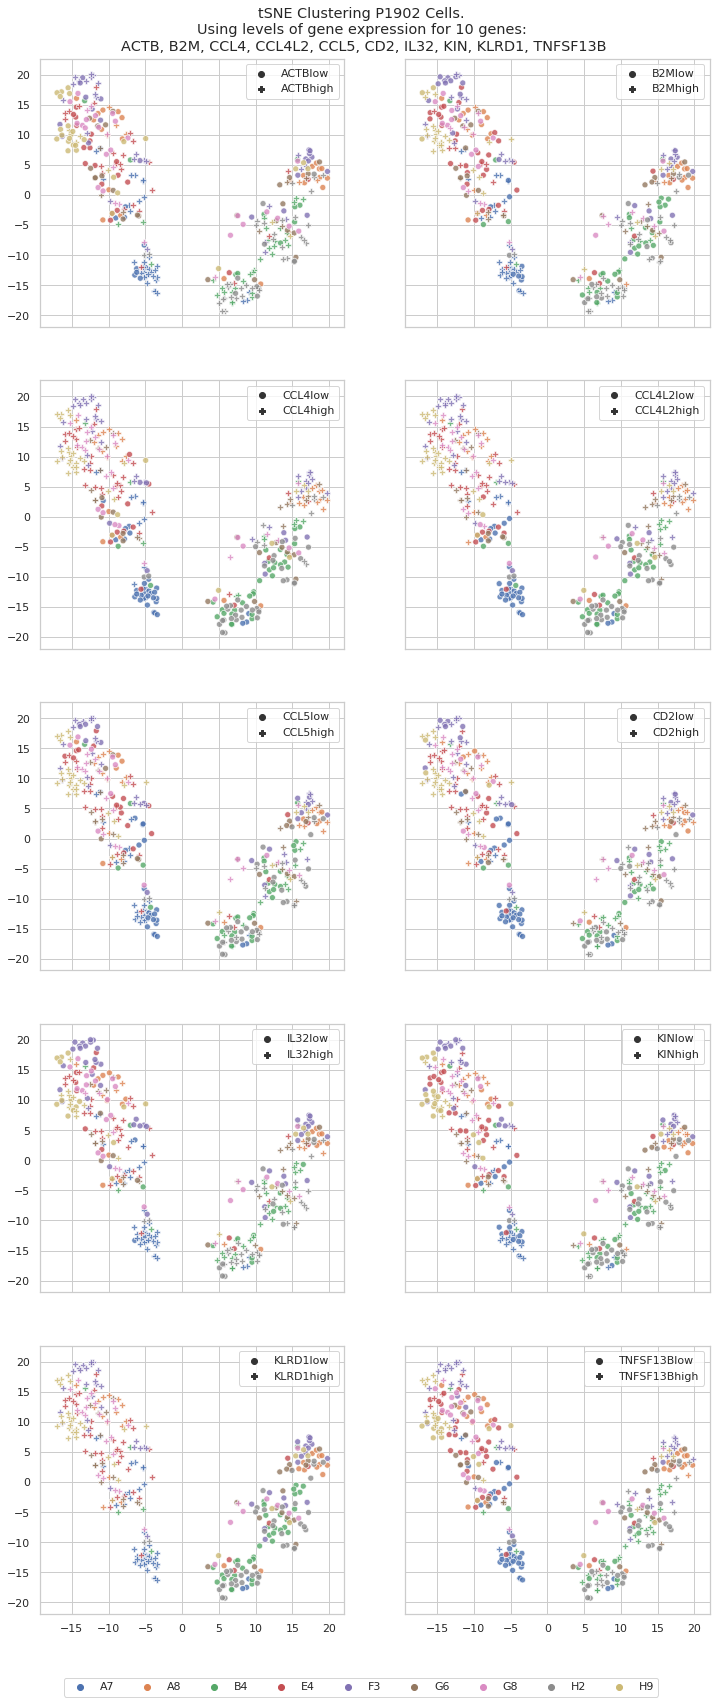

In [214]:
sns.set(style="whitegrid")
f, ax = plt.subplots(5,2,figsize=(12,24), 
                     sharex=True, sharey=True)

for i in range(5):
    for j in range(2):
        gene = g_genes[2*i + j]
        sp = sns.scatterplot(*zip(*X_embedded), hue=y, alpha=0.8,
                             style=sty_gene(X,gene), 
                             style_order = [gene+'low', gene+'high'],
                             markers = ['o', 'P'],
                             ax=ax[i,j])
        handles, labels = ax[i,j].get_legend_handles_labels()
        handles = handles[-2:]
        labels = labels[-2:]
        
        ax[i,j].legend(handles, labels, title=None)
        
f.suptitle("tSNE Clustering P1902 Cells. \n"
             "Using levels of gene expression for {} genes: \n"
             "{}".format(len(g_genes),', '.join(g_genes)))
handles, labels = ax[0,0].get_legend_handles_labels()
handles = handles[1:-3]
labels = labels[1:-3]
plt.figlegend( handles, labels, loc = 'lower center', ncol=9)
plt.subplots_adjust(bottom=0.05, top=0.95)
plt.show()

The differential expression of these ten frequently expressed genes leads to an interesting clustering.  There are two main clusters, which are completely determined by the high/low expression of KLRD1.  The A7 clones belong to the high KLRD1 group, but have wandered away from the other high KLRD1 cells a bit.  More specifically, the A7 clones exhibit higher expression of CCL4, CCL4L2, and CD2 than other high KLRD1 cells, and resemble the low KLRD1 cells of clonality B4 and H2 in this respect.

Now we carry out Type G clustering using a fuller set of 30 genes.

In [215]:
Gpipe = Pipeline([ ('expr',SelectKBest(express_score, k=360)), 
                    ('fval',SelectKBest(f_classif, k=30))]) 

# Takes a second or two.
Xred = Gpipe.fit_transform(X,y)
X_embedded = TSNE(n_components=2).fit_transform(Xred)

//anaconda/envs/Genomics/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [216]:
exp_gene_nums = Gpipe.named_steps['expr'].get_support(indices=True)
exp_genes = list(X.columns[exp_gene_nums])
g_gene_nums = list(Gpipe.named_steps['fval'].get_support(indices=True))
g_genes = [exp_genes[gn] for gn in g_gene_nums]

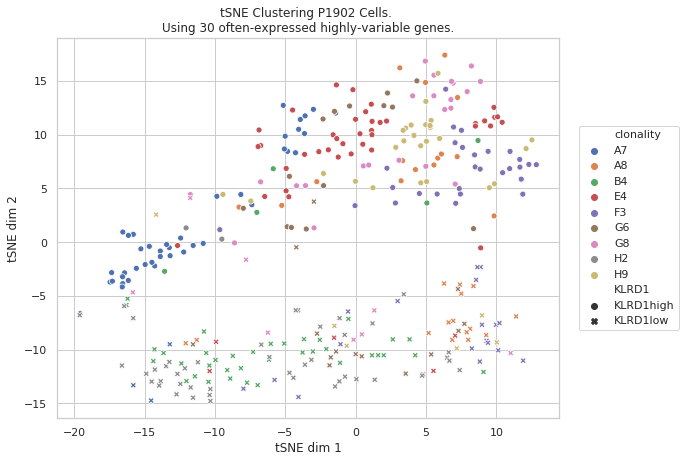

In [217]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(9,7))
sns.scatterplot(*zip(*X_embedded), hue=y, style=sty_gene(X,'KLRD1'))
ax.set_xlabel("tSNE dim 1")
ax.set_ylabel("tSNE dim 2")
ax.set_title("tSNE Clustering P1902 Cells. \n"
             "Using {} often-expressed highly-variable genes.".format(len(g_genes)))
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

Using 30 genes pulls apart the clonotypes a bit more, but the clusters are not as clear as with the Type B classifier.

## Application to data from another experiment

Now we apply some of these techniques to data from experiment P3128, to see how the classifiers hold up.  First we load the data.

In [224]:
P3128_df = pd.read_csv('cells_P3128.csv', sep=',',
                      index_col=0, header=0, low_memory=False).transpose()
display(P3128_df[:5])

,id,clonality,cell_number,norm_fsc,all_events_fsc_h_mean,norm_ssc,all_events_ssc_h_mean,cd57,fas,ptprc_cd45ra,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
2749,P3128_1193,D2,1,98626,87495,90903,84992,0,17391,623,...,0.003712478,0,0,0,0,0.577094809,0.027323136,0.829674035,0,0
2750,P3128_1194,D2,1,78641,82408,73829,81534,35,9330,194,...,0,0,0,0,0,0.119007399,0.804001732,617.5271293,0,0
2751,P3128_1195,D2,1,94524,92503,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0.100910862,0.306278632,31.48621092,0,218.5405354
2753,P3128_1197,D2,1,102274,89290,126799,87841,50,7071,89,...,0,0.901380341,0,0,31.95248205,1.075616709,2.20005141,0.66292331,0,411.7289122
2754,P3128_1198,D2,1,92162,91897,112074,87548,40,6554,93,...,47.51472906,265.7641196,0,0,0,0.348155438,0.081770718,0,0,0


We restrict attention to the genes we found relevant for the previous experiment.

In [225]:
genes3128 = [gene for gene in genes_relevant if gene in P3128_df.columns]
P3128_df = P3128_df[['clonality']+genes3128]
display(P3128_df[:5])

,clonality,A1BG,A2ML1,AAAS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZSWIM1,ZSWIM7,ZSWIM8,ZUFSP,ZWILCH,ZWINT,ZYG11B,ZYX,ZZEF1,ZZZ3
2749,D2,62.43835877,0,382.6467198,0.181204446,398.346226,68.48198295,0.212355956,0,0,...,0.14190444,0.212181251,29.50260876,0,0.003712478,0,0.027323136,0.829674035,0,0
2750,D2,0,0.564002082,0,0.422837562,0,199.7374373,1.765626308,814.2318924,0,...,0.023768812,1.504386082,825.9077445,0,0,0,0.804001732,617.5271293,0,0
2751,D2,22.4246804,15.61577489,0,6.20651635,509.4584823,36.2713044,0.00601477,80.6819608,289.3179336,...,0.835844125,13.24000229,0,0.941338045,0,0,0.306278632,31.48621092,0,218.5405354
2753,D2,0,1.479006677,0,483.2310209,0,54.65807182,11.67121939,0,0,...,0.038517361,1.971102077,0,0,0,0.901380341,2.20005141,0.66292331,0,411.7289122
2754,D2,0,1.355145888,0,0.560821066,0.668083122,2.761800091,0.284765686,299.3904526,120.8133736,...,0.020826098,1.633009758,0,0,47.51472906,265.7641196,0.081770718,0,0,0


This experiment has many more clonotypes, with smaller populations in each.

In [226]:
clones_3128 = P3128_df['clonality'].unique() 

#  Just for convenience later.
#noclones = len(clones_3128)
#noclones_two = 2*noclones
#noclones_three = 3*noclones

#  Make population table of clonotypes
clonepop3128 = P3128_df['clonality'].value_counts().rename_axis('clonotype')
clonepop3128_df = clonepop3128.reset_index(name='N') # Put the clone populations in a dataframe.
clonepop3128_df.set_index('clonotype', inplace=True)
clonepop3128_df['proportion'] = clonepop3128_df['N'] / clonepop3128_df['N'].sum()

print("The populations of each of the {} clonotypes are displayed below.".format(len(clones_3128)))
display(clonepop3128_df.transpose())

The populations of each of the 24 clonotypes are displayed below.


clonotype,F4,E7,G3,E2,B4,A7,E8,A2,C6,B10,...,C2,F7,D2,F11,A8,B6,D6,H4,F6,B12
N,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,13.000000,...,13.000000,13.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,11.00000,11.00000
proportion,0.045016,0.045016,0.045016,0.045016,0.045016,0.045016,0.045016,0.045016,0.045016,0.041801,...,0.041801,0.041801,0.038585,0.038585,0.038585,0.038585,0.038585,0.038585,0.03537,0.03537


Here we log-normalize the data, in the same way we did with the previous experiment.

In [227]:
genedf3128_log = P3128_df[genes3128].copy()  # Make a copy in memory
genedf3128_log = pd.DataFrame(genedf3128_log, dtype=np.float64) # Oops, change datatype.
genedf3128_log.clip_lower(0, inplace = True) # Clip negative counts to zero.
genedf3128_log = genedf3128_log.transform(np.log1p) # Apply log(1+x) transform.

df3128 = pd.concat([P3128_df['clonality'], genedf3128_log[genes3128]], axis=1)
display(df3128[:5]) # Let's take a look at the first five cells.

,clonality,A1BG,A2ML1,AAAS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZSWIM1,ZSWIM7,ZSWIM8,ZUFSP,ZWILCH,ZWINT,ZYG11B,ZYX,ZZEF1,ZZZ3
2749,D2,4.150069,0.000000,5.949722,0.166535,5.989829,4.241067,0.192566,0.000000,0.000000,...,0.132697,0.192421,3.417812,0.000000,0.003706,0.000000,0.026957,0.604138,0.0,0.000000
2750,D2,0.000000,0.447248,0.000000,0.352653,0.000000,5.301998,1.017267,6.703473,0.000000,...,0.023491,0.918044,6.717693,0.000000,0.000000,0.000000,0.590007,6.427341,0.0,0.000000
2751,D2,3.153790,2.810353,0.000000,1.974986,6.235309,3.618224,0.005997,4.402833,5.670977,...,0.607504,2.656055,0.000000,0.663377,0.000000,0.000000,0.267182,3.480816,0.0,5.391537
2753,D2,0.000000,0.907858,0.000000,6.182562,0.000000,4.019227,2.539333,0.000000,0.000000,...,0.037794,1.088933,0.000000,0.000000,0.000000,0.642580,1.163167,0.508577,0.0,6.022791
2754,D2,0.000000,0.856603,0.000000,0.445212,0.511675,1.324898,0.250576,5.705083,4.802490,...,0.020612,0.968128,0.000000,0.000000,3.881867,5.586365,0.078599,0.000000,0.0,0.000000


For machine learning, we create an matrix of features XX and classes yy.

In [228]:
XX = df3128[genes3128]  # The features.
yy = df3128.clonality # We are trying to predict clonality from the features.

### Prediction of clonotype from Type B classifier.

In [229]:
BNBpipe = make_pipeline(Binarizer(), SelectKBest(score_func = chi2), BernoulliNB())

In [231]:
import warnings
warnings.filterwarnings('ignore')  # Otherwise, a lot of divide-by-zero warnings!

param_grid = dict(binarizer__threshold=[1.0, 2.0, 3.0, 4.0, 5.0],
                  selectkbest__k = range(10,201,20),
                 )

grid_search = GridSearchCV(BNBpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(XX,yy)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('binarizer', Binarizer(copy=True, threshold=0.0)), ('selectkbest', SelectKBest(k=10, score_func=<function chi2 at 0x1c1a6be488>)), ('bernoullinb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'binarizer__threshold': [1.0, 2.0, 3.0, 4.0, 5.0], 'selectkbest__k': range(10, 201, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

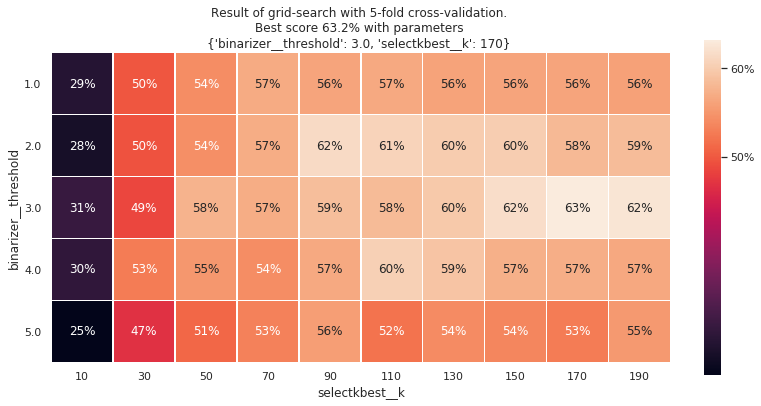

In [233]:
CV_map(grid_search)

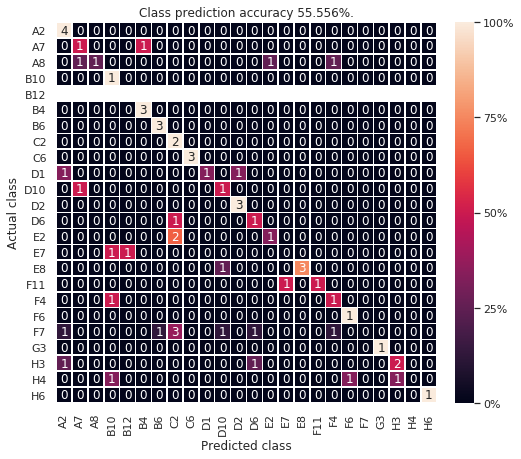

In [262]:
BNBpipe = make_pipeline(Binarizer(threshold=3.0), 
                        SelectKBest(score_func = chi2, k=170), 
                        BernoulliNB())
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.2)

BNBpipe.fit(XX_train, yy_train)
yy_pred = BNBpipe.predict(XX_test)
validate_map(yy_pred,yy_test)

The accuracy of the Type B (Binarized, Bernoulli Naive Bayes) classifier is above 50% on this experiment.  That doesn't sound great, but it's pretty impressive since (1) there are 24 clonotypes, so one would expect around 4% accuracy by chance, and (2) there are only 12-14 cells per clonotype, so the training population is only about 9-10 cells per clonotype. 

Next, we examine some "significant" genes in this experiment, and tSNE clustering based on binarized expression of a large number of genes.

In [268]:
SKB = SelectKBest(score_func = chi2, k=10)

In [269]:
column_numbers = SKB.fit(XX,yy).get_support(indices=True) #list of integers
Bgenes3128 = list(XX.columns[column_numbers])

In [270]:
print(Bgenes3128)

['CAPG', 'EPAS1', 'GPR15', 'GTSF1', 'GZMK', 'HPGD', 'KLRB1', 'KLRC1', 'REG4', 'SELL']


In [271]:
BNBpipe = make_pipeline(Binarizer(threshold=3.0), 
                        SelectKBest(score_func = chi2, k=170)) 
# Takes a second or two.
XXred = BNBpipe.fit_transform(XX,yy)
XX_embedded = TSNE(n_components=2).fit_transform(XXred)

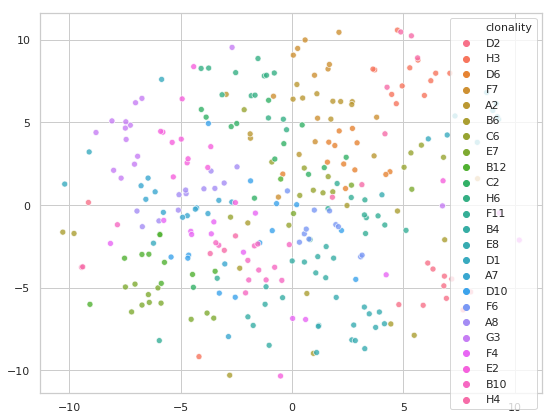

In [272]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(9,7))
sns.scatterplot(*zip(*XX_embedded), hue=yy, alpha=0.8)

Clusters are definitely less evident in this experiment -- but the large number of clonotypes makes it hard to see the difference anyways.  The visualization has limited value.

### Linear support vector machine

Since LinearSVC gave the most accurate classifier in the previous experiment, we try this in the P3128 experiment here.  The methods are the same, so we go quickly through it.

In [273]:
SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=100), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000))
SVMpipe

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=100, score_func=<function f_classif at 0x1c1a6be378>)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))])

In [274]:
param_grid = dict(linearsvc__C=[0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
                  selectkbest__k = range(50,501,50),
                 )

grid_search = GridSearchCV(SVMpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(XX,yy)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=100, score_func=<function f_classif at 0x1c1a6be378>)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'linearsvc__C': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0], 'selectkbest__k': range(50, 501, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

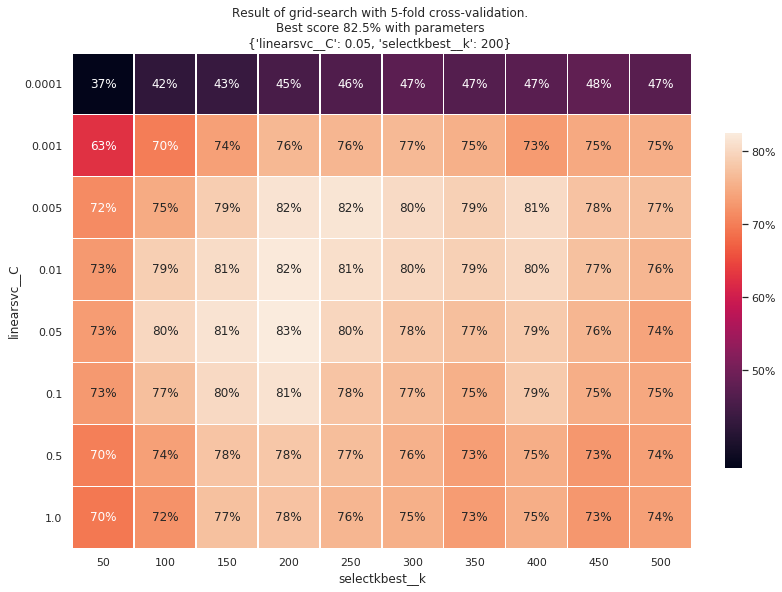

In [275]:
CV_map(grid_search)

Grid-search cross-validation finds that with 200 genes and C-parameter 0.05, the LinearSVC classifier achieves 82.5% accuracy.  This is pretty remarkable, given the small sample size (per clonotype) and the large number of clonotypes!  Just to see the classifier in action, we apply it with optimized parameters and plot the confusion matrix. 

In [278]:
SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=200), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=0.05))
SVMpipe

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=200, score_func=<function f_classif at 0x1c1a6be378>)), ('linearsvc', LinearSVC(C=0.05, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))])

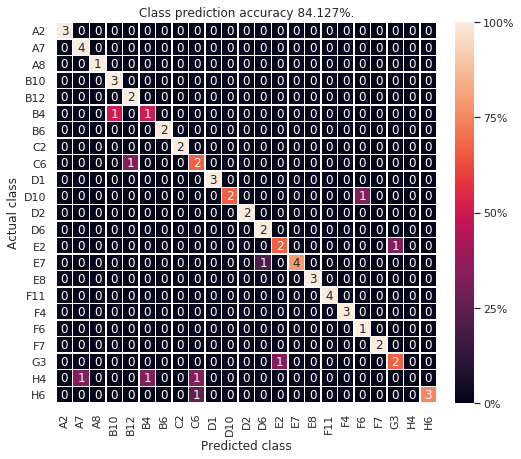

In [280]:
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.2)

SVMpipe.fit(XX_train, yy_train)
yy_pred = SVMpipe.predict(XX_test)
validate_map(yy_pred,yy_test)

Not too shabby.  I'd say that gene expression does a good job of predicting clonotype.